# Graphene Large Block Analysis

The purpose of this notebook is to (numerically) determine the asymptotic number of bytes required per transaction in a Graphene block. This analysis assumes canonical transaction ordering (CTOR) is used (i.e. no ordering information need be part of the block). And, for simplicity, we also ignore the number of bytes required for sending missing transactions.

Each curve in the plot below shows the number of bytes required, per transaction, for a block with variable size and assuming a given number of transactions in the receiver mempool, stated as a multiple of the block size. For example, when "mempool / block" is 1, we assume the mempool contains exactly the contents of the block. And when "mempool / block" is 2, we assume that the mempool contains all $n$ transaction in the block, plus another $n$ extraneous transactions.

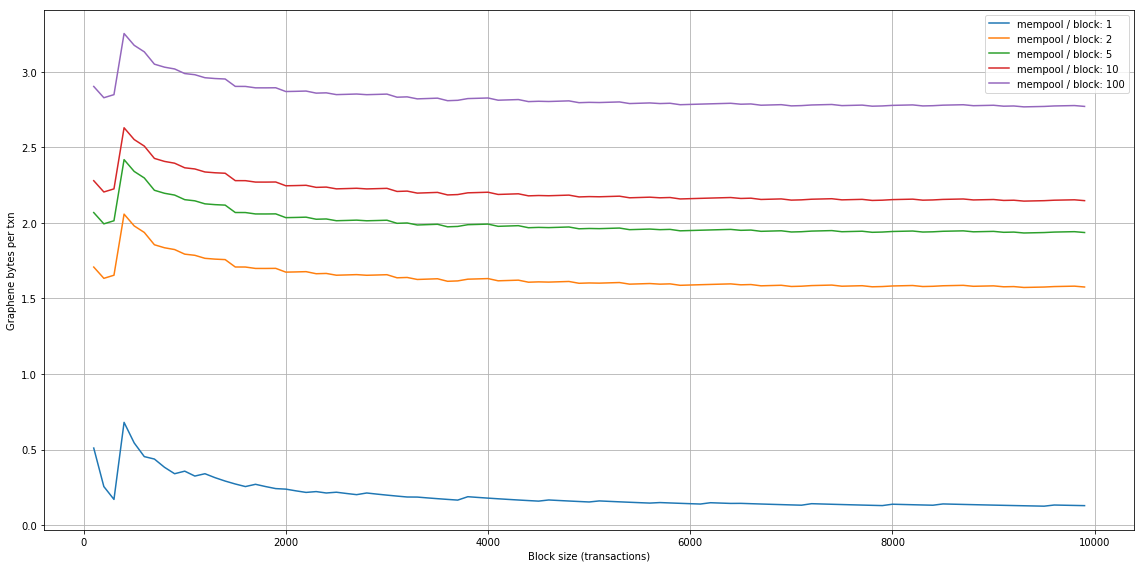

In [34]:
# setup
from collections import defaultdict
import numpy as np
import pylab as plt
import re
import requests
import sys

np.seterr(all='raise')

# Actual values in c++ implementation
# IBLT cell bytes
i = 17; 
# Default IBLT hash funcs
v_default = 4
# Bloom filter cell byts
b = 1; 

# populate optimal IBLT overhead and hash functions
response = requests.get('https://raw.githubusercontent.com/BitcoinUnlimited/\
BitcoinUnlimited/release/src/iblt_params.h')
matches = re.findall('{(.*?), IbltParamItem\((.*?), (.*?)\)}', response.text)
s_v_map = defaultdict(lambda: 1.5)
s_k_map = defaultdict(lambda: 4)
for match in matches:
    s_v_map[int(match[0])] = float(match[1])
    s_k_map[int(match[0])] = int(match[2])

# Function derivations found at https://github.com/bissias/graphene-experiments/blob/master/jupyter/graphene_size_optimization.ipynb
# Bloom filter false positive rate
def f_B(s, e): return 1.0 if s > e or e == 0 else s / e
# Bloom filter bytes
def B(s, e, n): return b * n / 8.0 * (-1 / np.log(2)**2) * np.log(f_B(s, e))
# IBLT bytes
def I(s, i): return i * s_v_map[s] * s
# Total Graphene block bytes (minus missing txs)
def T(s, e, n, i): return I(s, i) + B(s, e, n)
# Optimal IBLT symmetric difference size
def s_opt(n, i): return max(1, round(b * n / (8 * i * v_default * np.log(2)**2)))

ns = np.arange(100, 10000, 100)
mults = [1, 2, 5, 10, 100]
f, ax = plt.subplots(1, 1, figsize=(16,8))
for mult in mults:
    Ts = [T(s_opt(n, i), n*(mult-1), n, i)/n for n in ns]
    ax.plot(ns, Ts, label='mempool / block: %d' % mult)
ax.set_xlabel('Block size (transactions)')
ax.set_ylabel('Graphene bytes per txn')
ax.grid(True)
plt.legend(loc='best')
plt.tight_layout()